# Download the Dataset

In [2]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O /tmp/cats_and_dogs_filtered.zip

--2023-12-21 11:50:49--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c03::cf, 2607:f8b0:4023:c06::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   239MB/s    in 0.3s    

2023-12-21 11:50:49 (239 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



# Import the Packages

In [3]:
import os
import zipfile
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
import matplotlib.pyplot as plt
%matplotlib inline

# Extract the Images Dataset

In [4]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Setup the Images Directories

In [5]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Configure the Inception V3 Model

## Download the weights of the Model

In [6]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-12-21 11:51:00--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c03::cf, 2607:f8b0:4023:c06::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   147MB/s    in 0.6s    

2023-12-21 11:51:01 (147 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



## Configure the Inception V3 Model

In [7]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [8]:
pre_trained_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights=None)

In [9]:
pre_trained_model.load_weights(local_weights_file)

In [10]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

In [11]:
# Freeze the Layers
for layer in pre_trained_model.layers:
  layer.trainable = False

In [12]:
# Retrieve the last layer
last_layer = pre_trained_model.get_layer(name='mixed7')
print('Last Layer Output Shape: ', last_layer.output_shape)

Last Layer Output Shape:  (None, 7, 7, 768)


In [13]:
# Output of the last layer
last_output = last_layer.output

## Setup the Model

In [14]:
x = layers.Flatten()(last_output)

x = layers.Dense(units=1024, activation='relu')(x)

x = layers.Dropout(rate=0.2)(x)

x = layers.Dense(units=1, activation='sigmoid')(x)

In [15]:
model = Model(pre_trained_model.input, x)

In [16]:
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['acc'])

# Configure the ImageDataGenerator

In [17]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255)

In [18]:
train_generator = train_datagen.flow_from_directory(directory=train_dir, target_size=(150, 150), batch_size=20, class_mode='binary')

test_generator = test_datagen.flow_from_directory(directory=validation_dir, target_size=(150, 150), batch_size=20, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Train the model

In [19]:
history = model.fit_generator(generator=train_generator, steps_per_epoch=100, epochs=20, validation_data=test_generator, validation_steps=50, verbose=1)

<ipython-input-19-10053a7a51fc>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator, steps_per_epoch=100, epochs=20, validation_data=test_generator, validation_steps=50, verbose=1)


Epoch 1/20
100/100 [==============================] - 27s 184ms/step - loss: 0.3454 - acc: 0.8670 - val_loss: 0.2084 - val_acc: 0.9110
Epoch 2/20
100/100 [==============================] - 17s 168ms/step - loss: 0.2175 - acc: 0.9155 - val_loss: 0.1536 - val_acc: 0.9450
Epoch 3/20
100/100 [==============================] - 18s 178ms/step - loss: 0.1791 - acc: 0.9285 - val_loss: 0.1256 - val_acc: 0.9520
Epoch 4/20
100/100 [==============================] - 17s 168ms/step - loss: 0.1835 - acc: 0.9270 - val_loss: 0.0995 - val_acc: 0.9610
Epoch 5/20
100/100 [==============================] - 18s 179ms/step - loss: 0.1560 - acc: 0.9370 - val_loss: 0.0860 - val_acc: 0.9650
Epoch 6/20
100/100 [==============================] - 18s 175ms/step - loss: 0.1438 - acc: 0.9410 - val_loss: 0.1284 - val_acc: 0.9600
Epoch 7/20
100/100 [==============================] - 17s 167ms/step - loss: 0.1480 - acc: 0.9440 - val_loss: 0.1831 - val_acc: 0.9420
Epoch 8/20
100/100 [==============================] - 1

# Evaluating Accuracy and Loss

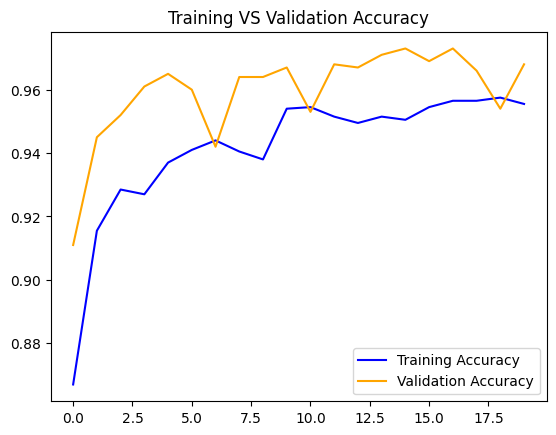

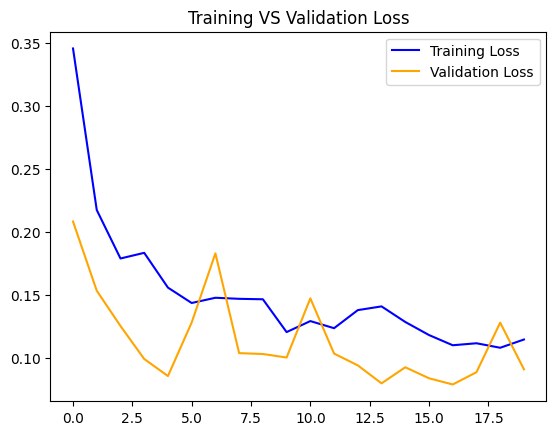

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, color='blue', label='Training Accuracy')
plt.plot(epochs, val_acc, color='orange', label='Validation Accuracy')
plt.title('Training VS Validation Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, color='blue', label='Training Loss')
plt.plot(epochs, val_loss, color='orange', label='Validation Loss')
plt.title('Training VS Validation Loss')
plt.legend()
plt.show()

# Test the model on new images [Use google colab]

In [21]:
class_names = ['Cat', 'Dog']
#Save the trained model to an H5 file
#model.save('/tmp/cats_vs_dogs_model.h5')

#Download the H5 file
#files.download('/tmp/cats_vs_dogs_model.h5')

<b>Note</b> : <i>You might have to run the below cell twice.</i>

Saving anjing.jpg to anjing.jpg
1/1 [==============================] - 2s 2s/step


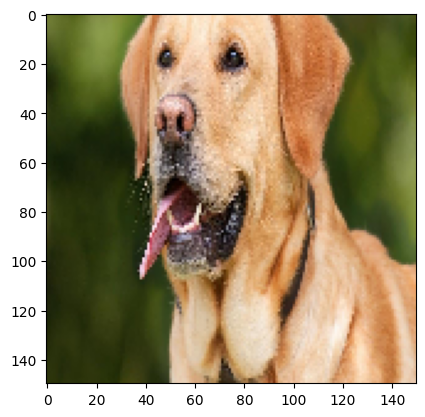

Prediction: Dog


In [22]:
uploaded = files.upload()

for file_name in uploaded.keys():

  path = file_name

  img = image.load_img(path, target_size=(150, 150))

  x = image.img_to_array(img)

  x = np.expand_dims(x, axis=0)

  x /= 255.

  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)

  plt.imshow(img)
  plt.grid(False)
  plt.show()

  if classes[0][0] > 0.6:
    print('Prediction: {}'.format(class_names[1]))
  else:
    print('Prediction: {}'.format(class_names[0]))

# Save the model

In [23]:
export_dir = "./saved_model_v1"
tf.saved_model.save(model, export_dir)

# Create a zip file to download the model locally

In [24]:
shutil.make_archive(base_name="saved_model_v1",format="zip",root_dir="saved_model_v1")
#Save the trained model to an H5 file
#model.save('/tmp/cats_vs_dogs_model.h5')

#Download the H5 file
#files.download('/tmp/cats_vs_dogs_model.h5')

'/content/saved_model_v1.zip'

# Load the saved model


In [ ]:
keras_model = tf.keras.models.load_model(export_dir)

In [ ]:
uploaded = files.upload()

for file_name in uploaded.keys():

  path = file_name

  img = image.load_img(path, target_size=(150, 150))

  x = image.img_to_array(img)

  x = np.expand_dims(x, axis=0)

  x /= 255.

  images = np.vstack([x])

  classes = keras_model.predict(images, batch_size=10)

  plt.imshow(img)
  plt.grid(False)
  plt.show()

  if classes[0][0] > 0.6:
    print('Prediction: {}'.format(class_names[1]))
  else:
    print('Prediction: {}'.format(class_names[0]))